In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE  # For oversampling

# Load the dataset
df = pd.read_csv(r"C:\Users\evanj\Downloads\BCA Files\ML\ml_dataset\healthcare_dataset.csv\healthcare_dataset.csv")

# Data Preprocessing
# Fill missing values
for column in df.select_dtypes(include=['float64', 'int64']).columns:
    df[column] = df[column].fillna(df[column].median())  # Fill numerical columns with median
for column in df.select_dtypes(include=['object']).columns:
    df[column] = df[column].fillna(df[column].mode()[0])  # Fill categorical columns with mode

# Remove duplicates
df.drop_duplicates(inplace=True)

# Encode categorical features
label_encoder = LabelEncoder()
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
for col in categorical_columns:
    df[col] = label_encoder.fit_transform(df[col])

# Standardize numerical columns
scaler = StandardScaler()
numerical_columns = [col for col in df.select_dtypes(include=['float64', 'int64']).columns]
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# Splitting data into features and target
target_column = 'Medical Condition'  # Replace with your actual target column
X = df.drop(columns=[target_column], axis=1)
y = df[target_column]

# Check class distribution
print("Class Distribution:\n", y.value_counts())


Class Distribution:
 Medical Condition
0    9218
3    9216
4    9151
5    9146
2    9140
1    9095
Name: count, dtype: int64


In [3]:
# Handle class imbalance using SMOTE (Synthetic Minority Oversampling Technique)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check new class distribution
print("New Class Distribution (After SMOTE):\n", pd.Series(y_resampled).value_counts())


New Class Distribution (After SMOTE):
 Medical Condition
2    9218
5    9218
3    9218
1    9218
4    9218
0    9218
Name: count, dtype: int64


In [5]:
# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Pre-pruning Decision Tree
dt_model_pre_prune = DecisionTreeClassifier(random_state=42, max_depth=10, min_samples_split=5, min_samples_leaf=3, class_weight='balanced')
dt_model_pre_prune.fit(X_train, y_train)
dt_predictions_pre_prune = dt_model_pre_prune.predict(X_test)

# Evaluate pre-pruning
print("\nDecision Tree Performance with Pre-pruning:")
print(classification_report(y_test, dt_predictions_pre_prune, zero_division=0))
dt_accuracy_pre_prune = accuracy_score(y_test, dt_predictions_pre_prune)
print(f"Accuracy (Pre-pruning): {dt_accuracy_pre_prune * 100:.2f}%")




Decision Tree Performance with Pre-pruning:
              precision    recall  f1-score   support

           0       0.16      0.01      0.03      1843
           1       0.29      0.01      0.02      1843
           2       0.16      0.09      0.11      1844
           3       0.17      0.65      0.27      1844
           4       0.17      0.10      0.12      1844
           5       0.16      0.14      0.15      1844

    accuracy                           0.17     11062
   macro avg       0.19      0.17      0.12     11062
weighted avg       0.19      0.17      0.12     11062

Accuracy (Pre-pruning): 16.62%


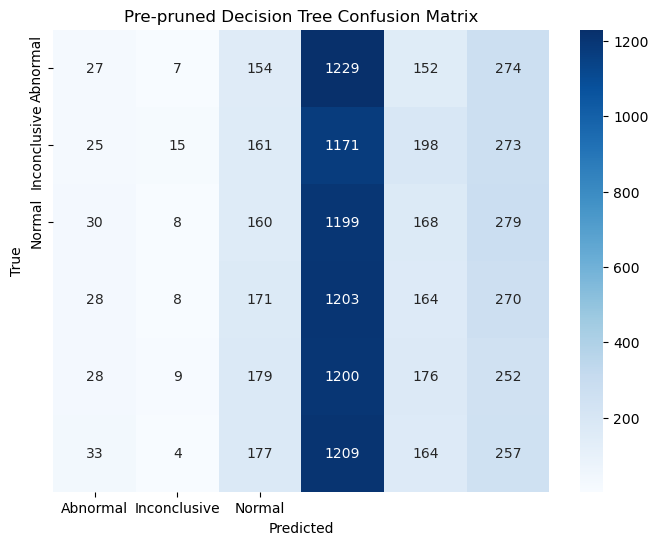


Decision Tree Performance with Post-pruning:
              precision    recall  f1-score   support

           0       0.26      0.25      0.25      1843
           1       0.28      0.27      0.27      1843
           2       0.25      0.27      0.26      1844
           3       0.26      0.26      0.26      1844
           4       0.27      0.27      0.27      1844
           5       0.27      0.27      0.27      1844

    accuracy                           0.27     11062
   macro avg       0.27      0.27      0.27     11062
weighted avg       0.27      0.27      0.27     11062

Accuracy (Post-pruning): 26.52%


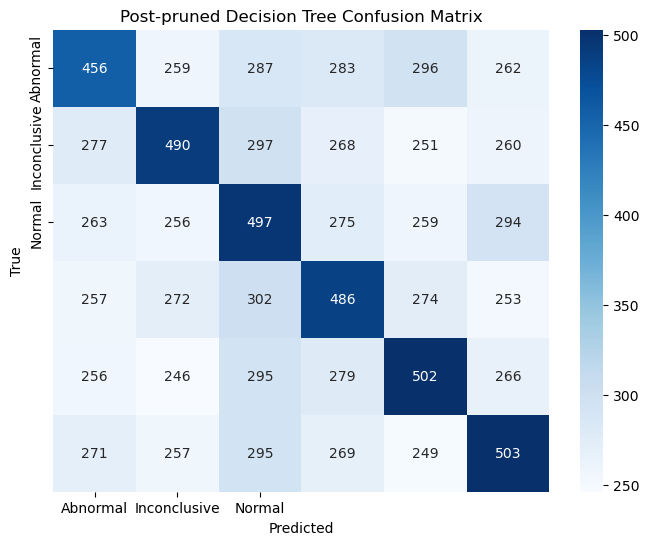

In [7]:
# Confusion matrix for pre-pruning
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, dt_predictions_pre_prune), annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Pre-pruned Decision Tree Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Post-pruning Decision Tree
dt_model_full = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt_model_full.fit(X_train, y_train)

# Cost complexity pruning path
path = dt_model_full.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path['ccp_alphas']

# Select the best alpha (smallest non-zero alpha)
best_alpha = ccp_alphas[1] if len(ccp_alphas) > 1 else ccp_alphas[0]
dt_model_post_prune = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha, class_weight='balanced')
dt_model_post_prune.fit(X_train, y_train)
dt_predictions_post_prune = dt_model_post_prune.predict(X_test)

# Evaluate post-pruning
print("\nDecision Tree Performance with Post-pruning:")
print(classification_report(y_test, dt_predictions_post_prune, zero_division=0))
dt_accuracy_post_prune = accuracy_score(y_test, dt_predictions_post_prune)
print(f"Accuracy (Post-pruning): {dt_accuracy_post_prune * 100:.2f}%")

# Confusion matrix for post-pruning
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, dt_predictions_post_prune), annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Post-pruned Decision Tree Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
